In [1]:
# Import the data and label coordinates



# Create label maps from the coordinates



In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms

loader = transforms.Compose([
  #transforms.Resize(img_size),
  #transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 

def load_image(filename, volatile=False):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    return image_tensor
    #image_var = Variable(image_tensor, volatile=volatile).unsqueeze(0)
    #return image_var.cuda

plt.imshow(load_image('data/32.jpg').numpy().transpose(1,2,0))

In [9]:
import torch
import torch.nn.functional as F
from torch import nn
CPU_DEBUG = False

# Setup the model
%env CUDA_LAUNCH_BLOCKING=1
device = torch.device("cpu" if CPU_DEBUG else "cuda")

class CoarseFireDetector(nn.Module):
    # Your code goes here
    def __init__(self):
        super(CoarseFireDetector, self).__init__()
                                                #input_channels, output_channels, kernel_size
        self.layers = nn.ModuleList([nn.Conv2d(3, 16, 5, bias=True)])
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(16, 16, 5, stride=2, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(16, 8, 5, stride=2, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(8, 8, 3, stride=2, bias=True))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(8, 1, 3, stride=1, bias=True))
        #self.layers.append(nn.Sigmoid())
    
    def forward(self, input):
        out = input 
        print(input.dim())
        if input.dim() == 3:
            out = out.unsqueeze(0)
            for layer in self.layers:
                out = layer(out)
            return out.squeeze()
        else:
            for layer in self.layers:
                out = layer(out)
            return out 
    

env: CUDA_LAUNCH_BLOCKING=1


3
torch.Size([85, 115])


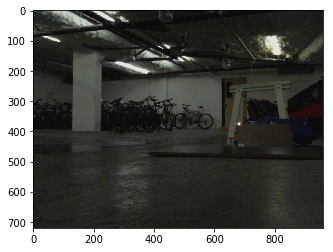

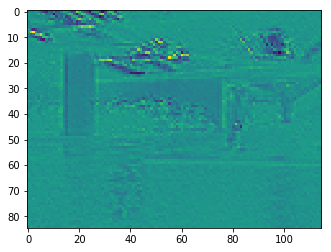

(85, 115)


In [10]:
cf_detector = CoarseFireDetector().cuda()
out = cf_detector(load_image('data/gucco/left/32.jpg').cuda())
print(out.size())
plt.imshow(load_image('data/gucco/left/32.jpg').numpy().transpose(1,2,0))
plt.show()
plt.imshow(out.cpu().detach().numpy())
plt.show()
print(out.cpu().detach().numpy().shape)
label_shape = out.cpu().detach().numpy().shape

In [11]:
import os
import pickle
import pprint

def show_torch_img(tensor):
    plt.imshow(tensor.detach().cpu().numpy().transpose(1,2,0))
    plt.show()

pp = pprint.PrettyPrinter(indent=2)

# Training Dataset
data = "data/gucco"
metadp = "metadata.dat"
metadata = None
with open(os.path.join(data, metadp), 'rb') as metadf:
    metadata = pickle.load(metadf)
    metadata = dict((k,metadata[k]) for k in range(76, 144))
    #pp.pprint(metadata)

# load the input imgs
input_imgs = []
coords = []
for i, num in enumerate(metadata):
    input_imgs.append(load_image(metadata[num]['left']['img_path']))
    coords.append(metadata[num]['left']['coords'])
    input_imgs.append(load_image(metadata[num]['right']['img_path']))
    coords.append(metadata[num]['right']['coords'])
    #print(coords[-2])
    #show_torch_img(input_imgs[-2])
    #show_torch_img(input_imgs[-1])

2D Gaussian-like array:
[[0.00193045 0.00757568 0.02011579 0.03614154 0.04393693 0.03614154
  0.02011579 0.00757568 0.00193045]
 [0.00757568 0.02972922 0.07894037 0.14183016 0.17242162 0.14183016
  0.07894037 0.02972922 0.00757568]
 [0.02011579 0.07894037 0.20961139 0.37660345 0.45783336 0.37660345
  0.20961139 0.07894037 0.02011579]
 [0.03614154 0.14183016 0.37660345 0.67663385 0.82257756 0.67663385
  0.37660345 0.14183016 0.03614154]
 [0.04393693 0.17242162 0.45783336 0.82257756 1.         0.82257756
  0.45783336 0.17242162 0.04393693]
 [0.03614154 0.14183016 0.37660345 0.67663385 0.82257756 0.67663385
  0.37660345 0.14183016 0.03614154]
 [0.02011579 0.07894037 0.20961139 0.37660345 0.45783336 0.37660345
  0.20961139 0.07894037 0.02011579]
 [0.00757568 0.02972922 0.07894037 0.14183016 0.17242162 0.14183016
  0.07894037 0.02972922 0.00757568]
 [0.00193045 0.00757568 0.02011579 0.03614154 0.04393693 0.03614154
  0.02011579 0.00757568 0.00193045]]
(9, 9)


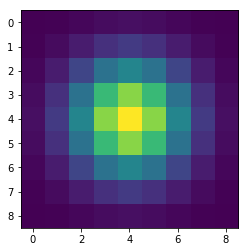

In [12]:
import numpy as np
x, y = np.meshgrid(np.linspace(-1,1,9), np.linspace(-1,1,9))
d = np.sqrt(x*x+y*y)
sigma, mu = 0.4, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
print("2D Gaussian-like array:")
print(g)
plt.imshow(g)
print(g.shape)

labels = []
for num, img in enumerate(input_imgs):
    #print(num)
    # Create labels
    #print(metadata[num])
    #print(input_imgs[num])
    label = np.zeros(label_shape)
    #print(coords[num])
    coord = coords[num][0]
    _, input_imgs_w, input_imgs_h = input_imgs[num].numpy().shape
    #print(input_imgs_w, input_imgs_h)
    #print(label_shape)
    #print(coord)
    central = (int(coord[0]/input_imgs_w*label_shape[0]), 
                    int(coord[1]/input_imgs_h*label_shape[1]))
    #print(central)
    #print(central)
    for i in range(-4, 5):
        for j in range(-4, 5):
            lx = min(max(central[1]+i, 0),label_shape[0]-1)
            ly = min(max(central[0]+j, 0),label_shape[1]-1)
            label[lx, ly] += g[i+4, j+4] 
    #show_torch_img(img)
    #plt.show()
    #plt.imshow(label)
    #plt.show()
    #show_torch_img
    labels.append(label)
 

In [15]:
from torch import FloatTensor
from torch import optim

cf_detector = CoarseFireDetector().cuda()

optimizer = optim.Adam(cf_detector.parameters(), lr = 0.001) 

n_epochs = 2
for i in range(n_epochs):
    for j, (img, label) in enumerate(zip(input_imgs, labels)):
        optimizer.zero_grad()
        out = cf_detector(img.cuda().unsqueeze(0))
        print(out.size())
        weights = np.zeros_like(label)
        weights[label<0.001] = 1.5
        weights[label>=0.001] = 1.0
        loss = torch.mean(FloatTensor(weights).cuda()*(FloatTensor(label).cuda()-out)**2)
        #loss = torch.sum((FloatTensor(label).cuda()-out)**2)
        loss.backward()
        optimizer.step()
        print(loss.item())
    

4
torch.Size([1, 1, 85, 115])
0.0020767133682966232
4
torch.Size([1, 1, 85, 115])
0.0008547376492060721
4
torch.Size([1, 1, 85, 115])
0.0008248550002463162
4
torch.Size([1, 1, 85, 115])
0.0008386326371692121
4
torch.Size([1, 1, 85, 115])
0.0008390517323277891
4
torch.Size([1, 1, 85, 115])
0.000829077500384301
4
torch.Size([1, 1, 85, 115])
0.0008207242353819311
4
torch.Size([1, 1, 85, 115])
0.0008223585900850594
4
torch.Size([1, 1, 85, 115])
0.0008266172953881323
4
torch.Size([1, 1, 85, 115])
0.0008269535028375685
4
torch.Size([1, 1, 85, 115])
0.000820177374407649
4
torch.Size([1, 1, 85, 115])
0.0008186906343325973
4
torch.Size([1, 1, 85, 115])
0.0008200891898013651
4
torch.Size([1, 1, 85, 115])
0.0008230238454416394
4
torch.Size([1, 1, 85, 115])
0.000822998583316803
4
torch.Size([1, 1, 85, 115])
0.0008231486426666379
4
torch.Size([1, 1, 85, 115])
0.0008229753584600985
4
torch.Size([1, 1, 85, 115])
0.0008257674053311348
4
torch.Size([1, 1, 85, 115])
0.0008232196560129523
4
torch.Size([1

0.0007938681519590318
4
torch.Size([1, 1, 85, 115])
0.0007720355060882866
4
torch.Size([1, 1, 85, 115])
0.0008220297750085592
4
torch.Size([1, 1, 85, 115])
0.0008239384042099118
4
torch.Size([1, 1, 85, 115])
0.0008231201791204512
4
torch.Size([1, 1, 85, 115])
0.0008211154490709305
4
torch.Size([1, 1, 85, 115])
0.0008041078690439463
4
torch.Size([1, 1, 85, 115])
0.0007680587586946785
4
torch.Size([1, 1, 85, 115])
0.0007882090867497027
4
torch.Size([1, 1, 85, 115])
0.0007319524302147329
4
torch.Size([1, 1, 85, 115])
0.0007515930919907987
4
torch.Size([1, 1, 85, 115])
0.0007223997381515801
4
torch.Size([1, 1, 85, 115])
0.0008219382725656033
4
torch.Size([1, 1, 85, 115])
0.0005271266563795507
4
torch.Size([1, 1, 85, 115])
0.0008580602589063346
4
torch.Size([1, 1, 85, 115])
0.00047449220437556505
4
torch.Size([1, 1, 85, 115])
0.0008489656611345708
4
torch.Size([1, 1, 85, 115])
0.0009338539675809443
4
torch.Size([1, 1, 85, 115])
0.00086544593796134
4
torch.Size([1, 1, 85, 115])
0.00086397654

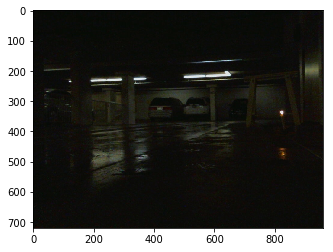

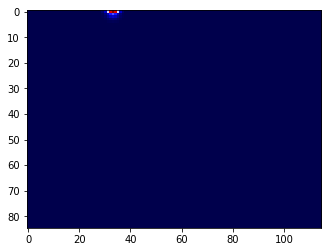

3


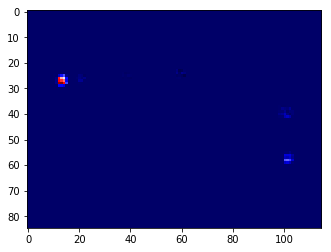

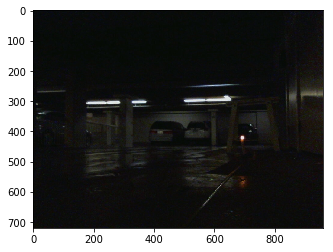

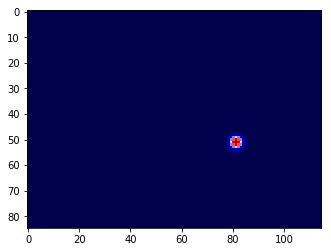

3


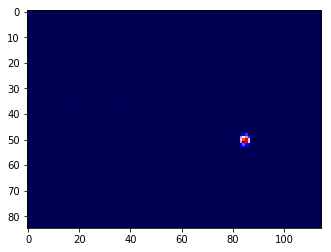

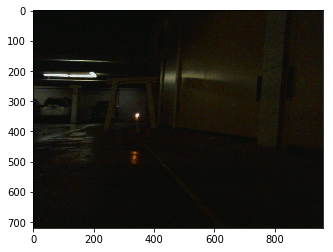

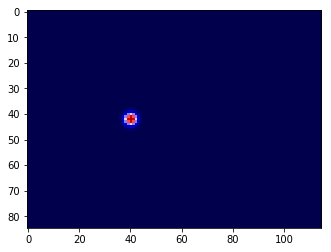

3


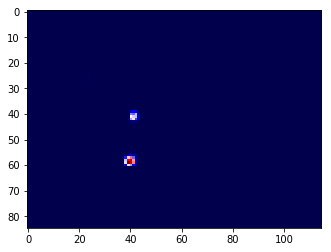

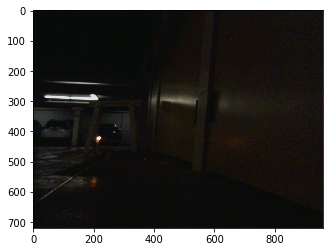

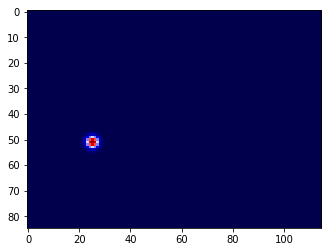

3


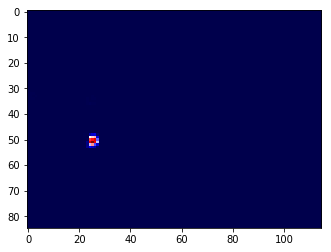

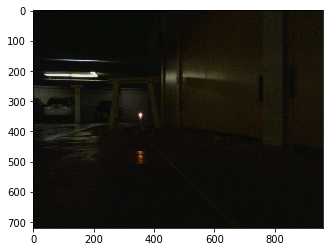

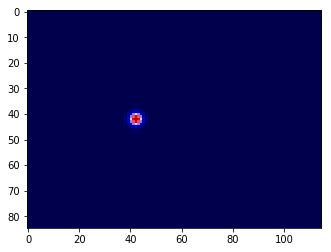

3


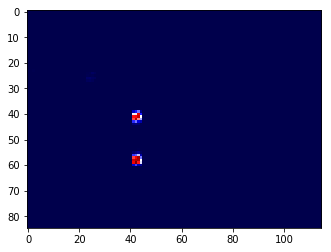

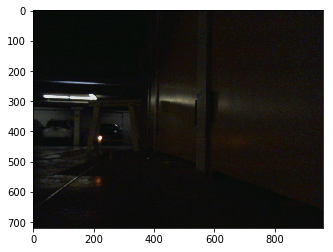

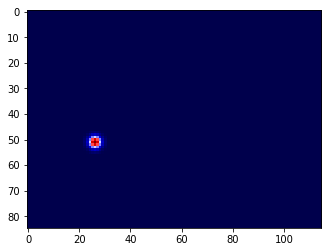

3


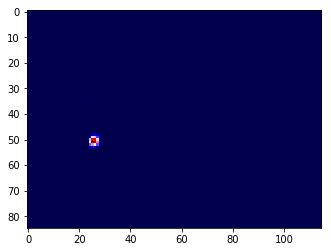

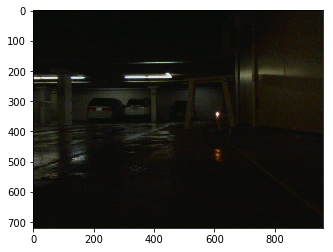

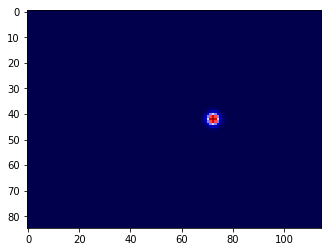

3


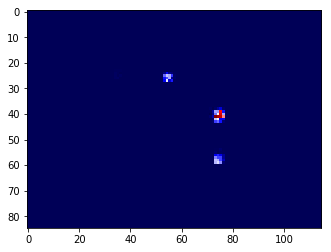

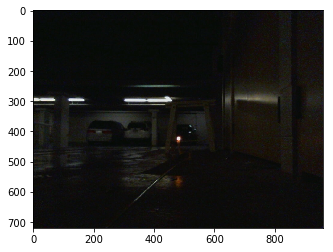

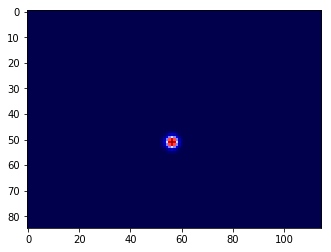

3


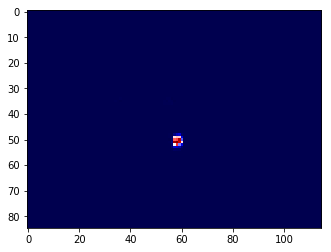

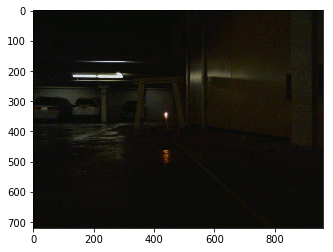

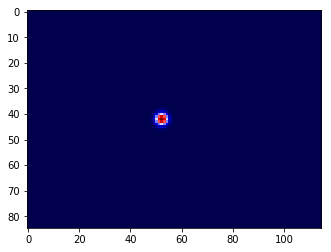

3


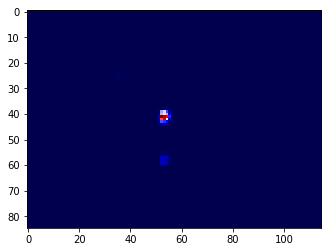

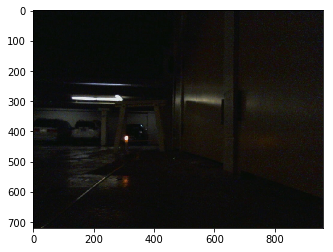

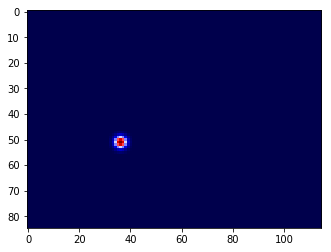

3


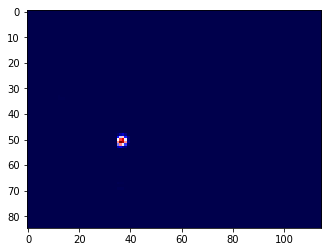

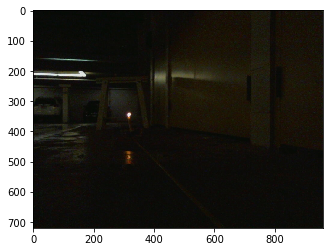

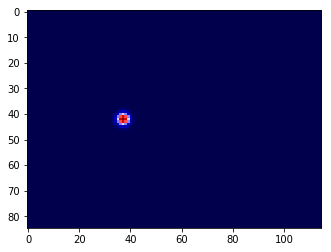

3


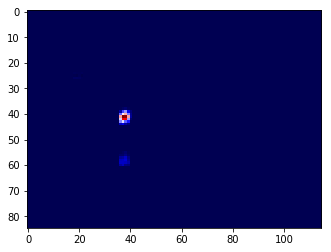

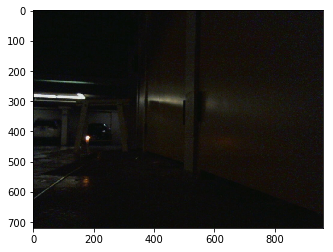

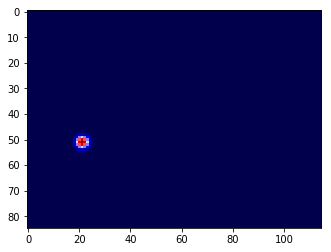

3


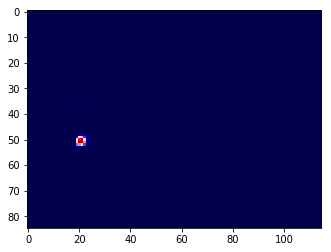

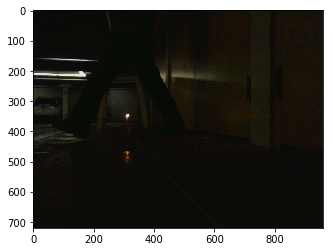

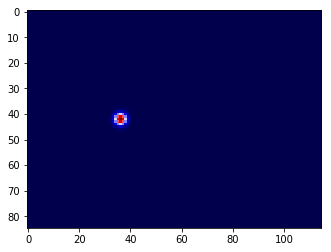

3


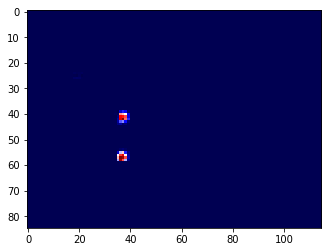

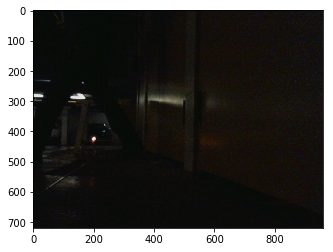

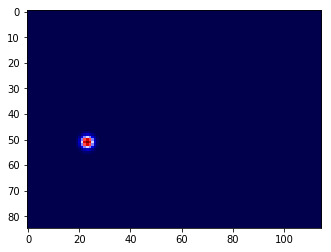

3


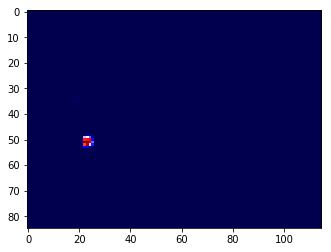

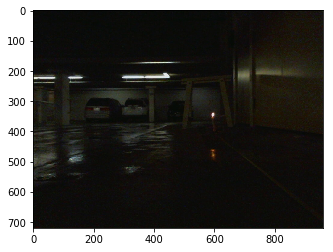

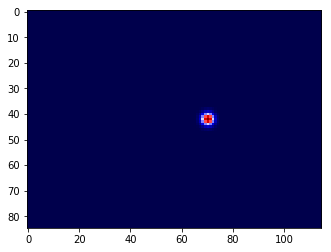

3


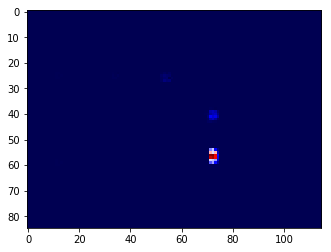

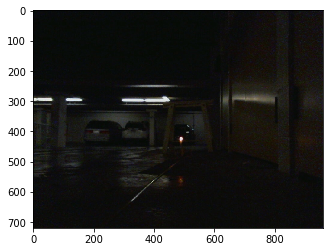

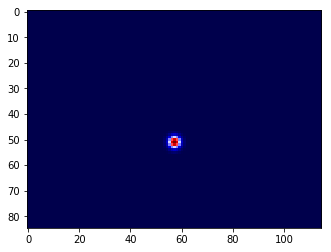

3


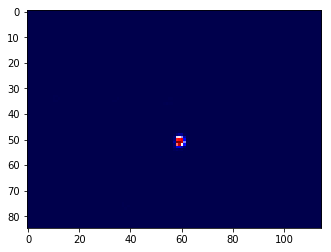

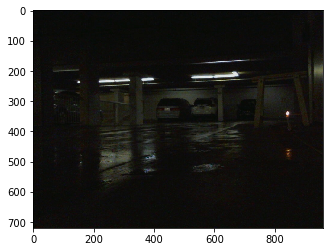

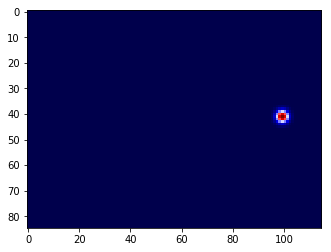

3


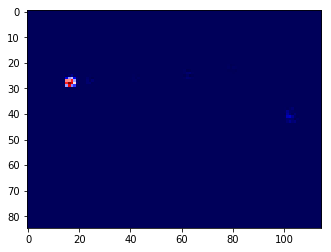

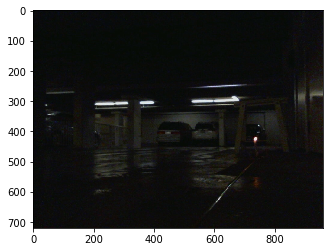

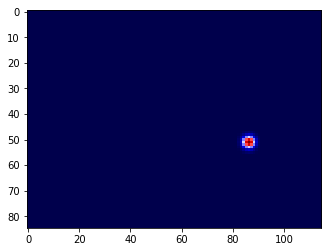

3


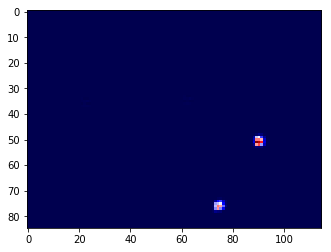

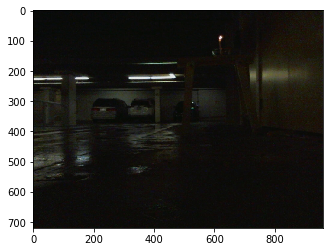

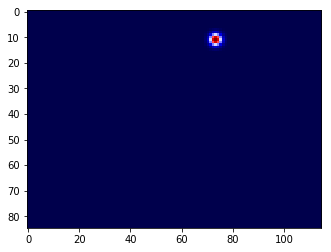

3


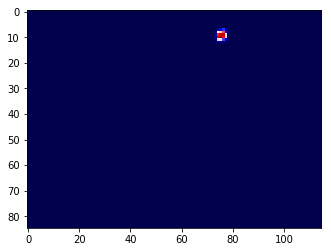

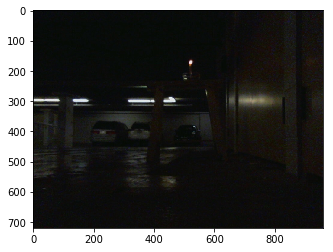

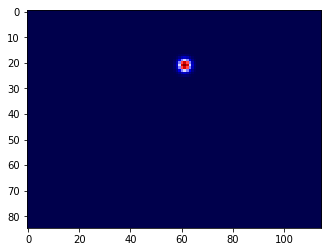

3


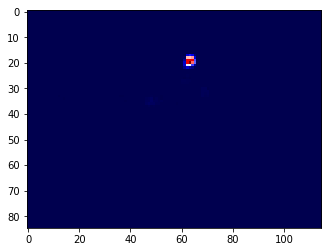

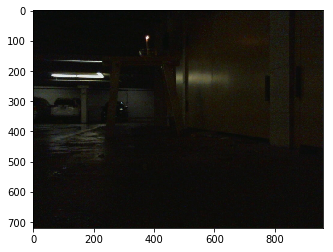

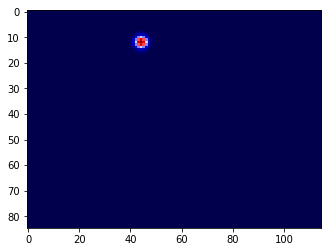

3


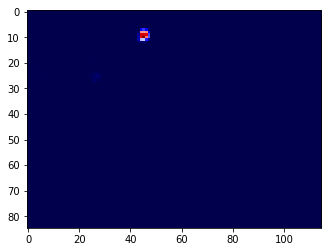

In [16]:
for j, (img, label) in enumerate(zip(input_imgs, labels)):
    if j>20:
        break
    show_torch_img(img)
    plt.imshow(label, cmap = "seismic")
    plt.show()
    plt.imshow(cf_detector.cuda()(img.cuda()).cpu().detach().numpy(), cmap = "seismic")
    plt.show()